In [4]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
import glob 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.preprocessing.image import load_img, img_to_array, array_to_img 
from keras.models import load_model 

%matplotlib inline

In [6]:
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

##### We will now load a sample image that is not a part of any of our datasets and try to see the predictions of our different models.

(1, 150, 150, 3)


TypeError: 'AxesImage' object is not callable

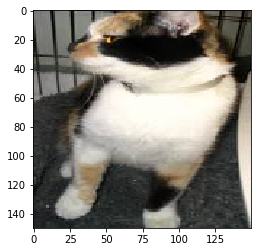

In [7]:
# basic configurations 
IMG_DIM = (150, 150) 
input_shape = (150, 150, 3) 
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for 
                                          x in l] 
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x   
                                         in l] 

# load sample image 
sample_img_path = 'data/test_data/cat.10025.jpg' 
sample_img = load_img(sample_img_path, target_size=IMG_DIM) 
sample_img_tensor = img_to_array(sample_img) 
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0) 
sample_img_tensor /= 255. 
print(sample_img_tensor.shape) 
plt.imshow(sample_img_tensor[0]) (1, 150, 150, 3)

In [10]:
# cnn_prediction = num2class_label_transformer(basic_cnn.predict_classes(
#                                                   sample_img_tensor, 
#                                                   verbose=0)) 
# cnn_img_aug_prediction = num2class_label_transformer(img_aug_cnn.predict_classes(
#                                                      sample_img_tensor,   
#                                                      verbose=0)) 
# tlearn_cnn_prediction = num2class_label_transformer(tl_cnn.predict_classes(  
#                                     get_bottleneck_features(vgg_model,                                                             
#                                     sample_img_tensor),  
#                                     verbose=0)) 
# tlearn_cnn_img_aug_prediction = num2class_label_transformer(  
#                       tl_img_aug_cnn.predict_classes(sample_img_tensor, verbose=0)) 


tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, verbose=0)) 

print('Predictions for our sample image:\n', 
#       '\nBasic CNN:', cnn_prediction, 
#       '\nCNN with Img Augmentation:', cnn_img_aug_prediction, 
#       '\nPre-trained CNN (Transfer Learning):', tlearn_cnn_prediction, 
#       '\nPre-trained CNN with Img Augmentation (Transfer Learning):',    tlearn_cnn_img_aug_prediction, 
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction) 

Predictions for our sample image:
 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['cat']


In [11]:
IMG_DIM = (150, 150)

test_files = glob.glob('data/test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

print('Test dataset shape:', test_imgs.shape)

Test dataset shape: (1000, 150, 150, 3)


In [12]:
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[0:5], test_labels_enc[0:5])

['test_data\\cat', 'test_data\\cat', 'test_data\\cat', 'test_data\\cat', 'test_data\\cat'] [1, 1, 1, 1, 1]


In [14]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 20:05:23 2017

@author: DIP
@Copyright: Dipanjan Sarkar
"""

from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Model Classification report:
------------------------------
               precision    recall  f1-score   support

test_data\cat       0.00      0.00      0.00       500
test_data\dog       0.00      0.00      0.00       500

  avg / total       0.00      0.00      0.00      1000


Prediction Confusion Matrix:
------------------------------
                         Predicted:              
                      test_data\cat test_data\dog
Actual: test_data\cat             0             0
        test_data\dog             0             0


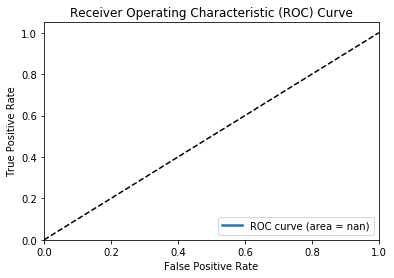

In [16]:
plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])